# htFuncLib 02

- This notebook comes after you have run the 01_htFuncLib_prepare_jobs notebook.
- The score_df you created in the 01 notebook is the starting point for this notebook.
- the notebook has 8 parts:
    1. Imports and initial setup
    2. Setting up the initial paramteres
    3. Parse the score dataframe created by the 01 notebook
    4. Training the neural net model
    5. Rank mutaitons by EpiNNet
    6. Choose mutations
    7. Find the best sequence space
    8. Test 10k designs

## 01 Imports and initial setup

In [307]:
import os
from pathlib import Path

import joblib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Bio.PDB.PDBParser import PDBParser
from matplotlib import rc
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from tqdm.notebook import tqdm

In [2]:
def display_all(df, n=1000):
    with pd.option_context("display.max_rows", n, "display.max_columns", 1000):
        display(df)

In [3]:
# load basic parameters, this requires no changes
AAs = list("ACDEFGHIKLMNPQRSTVWY")

BB_ATOMS = ["N", "CA", "C", "O"]
DDGS = np.arange(0, 6.5, 0.5)
ONE_2_THREE = {
    "A": "ALA",
    "C": "CYS",
    "D": "ASP",
    "E": "GLU",
    "F": "PHE",
    "G": "GLY",
    "H": "HIS",
    "I": "ILE",
    "K": "LYS",
    "L": "LEU",
    "M": "MET",
    "N": "ASN",
    "P": "PRO",
    "Q": "GLN",
    "R": "ARG",
    "S": "SER",
    "T": "THR",
    "V": "VAL",
    "W": "TRP",
    "Y": "TYR",
}
THREE_2_ONE = {v: k for k, v in ONE_2_THREE.items()}

## 02 Setting up the initial paramteres. 
This is where you use the files you got from FuncLib

In [266]:
# fields for user input

# path in which to create files and folders
W_PATH = Path("./").absolute()
DESIGN_PATH = "%s/bubb_design" % W_PATH
# path to Rosetta scripts executable
ROSETTA_SCRIPTS = "/home/labs/fleishman/rosaliel/Rosetta/main/source/build/src/release/linux/3.10/64/x86/gcc/5.4/default/rosetta_scripts.default.linuxgccrelease"
ROSETTA_DB = "/home/labs/fleishman/rosaliel/Rosetta/main/database"
# path to the refined PDB, retrieved from FuncLib
PDB_FILE = os.path.abspath(f"{W_PATH}/initial_data/refined.pdb")
pdb = PDBParser().get_structure("", PDB_FILE)
# the PDB chain to work on
CHAIN = "A"
# positions to work on
ALL_POSS = [
    42,
    44,
    46,
    61,
    64,
    68,
    69,
    110,
    112,
    145,
    150,
    163,
    165,
    167,
    181,
    201,
    220,
    224,
    14,
    16,
    18,
    72,
    108,
    119,
    123,
    185,
]
ALL_POSS_CHAIN = [f"{a}{CHAIN}" for a in ALL_POSS]
# path to the PSSM, retrieved from FuncLib
PSSM = f"{W_PATH}/initial_data/pssm"

RESFILES = {
    float(str(a)[-3:]): W_PATH / a
    for a in (W_PATH / "initial_data").glob("designable_aa_resfile.*.*")
}

LIGS = ["GYS"]
flags_file = W_PATH / "initial_data/flags"

CHOSEN_DDG = 3.0


def parse_flags(flags_file):
    flgs_to_ignore = ["database"]
    for l in open(flags_file):
        print(l.rstrip())
    return


flags = parse_flags(flags_file)

-pdb_gz
-overwrite
-use_input_sc
-extrachi_cutoff 5
-ignore_unrecognized_res
-chemical:exclude_patches LowerDNA UpperDNA Cterm_amidation SpecialRotamer VirtualBB ShoveBB VirtualDNAPhosphate VirtualNTerm CTermConnect sc_orbitals pro_hydroxylated_case1 pro_hydroxylated_case2 ser_phosphorylated thr_phosphorylated tyr_phosphorylated tyr_sulfated lys_dimethylated lys_monomethylated lys_trimethylated lys_acetylated glu_carboxylated cys_acetylated tyr_diiodinated N_acetylated C_methylamidated MethylatedProteinCterm
-linmem_ig 10
-ignore_zero_occupancy false
-mute all
-no_nstruct_label true
-in:file:native /home/labs/fleishman/jonathaw/gfp_lib/analysis/notebooks_for_publication/htFuncLib/htFuncLib_notebook/initial_data/refined.pdb
-extra_res_fa /home/labs/fleishman/jonathaw/gfp_lib/analysis/notebooks_for_publication/htFuncLib/htFuncLib_notebook/initial_data/LG.params
-s /home/labs/fleishman/jonathaw/gfp_lib/analysis/notebooks_for_publication/htFuncLib/htFuncLib_notebook/initial_data/refined.pd

In [228]:
def create_dir(name):
    if Path(name).exists():
        return
    else:
        os.mkdir(name)

## 03 Parse the score dataframe created by the 01 notebook

In [305]:
# load the bub_fl_summ_df if required
score_df = score_df = pd.read_csv(Path(DESIGN_PATH) / "score_df.csv")
score_df.drop(columns="mut_dict", inplace=True)
display_all(score_df, 10)

,SCORE:,total_score,coordinate_constraint,designable,dslf_fa13,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,lk_ball_wtd,omega,p_aa_pp,pro_close,rama_prepro,ref,yhh_planarity,description,42A,44A,46A,61A,64A,68A,69A,110A,112A,145A,150A,163A,165A,167A,181A,201A,220A,224A,14A,16A,18A,72A,108A,119A,123A,185A,L42,L44,F46,V61,L64,V68,Q69,A110,V112,Y145,V150,V163,F165,T167,H181,L201,L220,V224,I14,V16,L18,S72,T108,L119,I123,N185,num_muts
0,SCORE:,-723.948,1.034,126.0,0.0,-1368.315,288.487,-399.611,2.539,46.396,147.599,784.432,-42.247,-119.837,-51.317,-26.518,-14.113,32.150,-55.417,0.616,7.052,43.062,0.061,14AI_42AI_44AM_46AF_68AM_72AT_119AL_220AL_224A...,I,M,F,V,L,M,Q,A,V,Y,V,V,F,T,H,L,L,V,I,V,L,T,T,L,I,N,I,M,F,V,L,M,Q,A,V,Y,V,V,F,T,H,L,L,V,I,V,L,T,T,L,I,N,4
1,SCORE:,-722.231,0.952,125.0,0.0,-1363.764,284.696,-404.692,2.533,46.510,150.098,786.633,-41.045,-120.069,-51.817,-26.104,-13.437,31.450,-55.262,0.624,8.135,42.267,0.062,14AI_42AI_44AI_46AF_68AM_72AS_119AL_220AL_224A...,I,I,F,V,L,M,Q,A,V,Y,V,V,F,T,H,L,L,V,I,V,L,S,T,L,I,N,I,I,F,V,L,M,Q,A,V,Y,V,V,F,T,H,L,L,V,I,V,L,S,T,L,I,N,3
2,SCORE:,-728.819,1.403,123.0,0.0,-1356.934,284.763,-401.799,2.547,46.376,145.979,776.570,-41.093,-119.854,-52.010,-26.071,-13.276,31.292,-56.685,0.685,3.380,45.848,0.060,14AI_42AI_44AI_46AF_68AA_72AV_119AL_220AV_224A...,I,I,F,V,L,A,Q,A,V,Y,V,V,F,T,H,L,V,V,I,V,L,V,T,L,I,N,I,I,F,V,L,A,Q,A,V,Y,V,V,F,T,H,L,V,V,I,V,L,V,T,L,I,N,5
3,SCORE:,-716.175,1.670,127.0,0.0,-1358.593,290.850,-402.468,2.570,46.670,151.930,782.015,-42.584,-118.259,-52.086,-27.141,-14.186,31.699,-56.158,0.710,4.857,42.271,0.058,14AI_42AL_44AI_46AF_68AL_72AS_119AL_220AI_224A...,L,I,F,V,L,L,Q,A,V,Y,V,V,F,T,H,L,I,V,I,V,L,S,T,L,I,N,L,I,F,V,L,L,Q,A,V,Y,V,V,F,T,H,L,I,V,I,V,L,S,T,L,I,N,3
4,SCORE:,-719.694,0.771,123.0,0.0,-1359.891,284.000,-405.930,2.522,46.294,149.801,782.328,-41.310,-120.369,-52.207,-26.385,-13.832,31.156,-52.760,0.602,8.960,46.493,0.062,14AI_42AL_44AL_46AF_68AV_72AC_119AL_220AV_224A...,L,L,F,V,L,V,Q,A,V,Y,V,V,F,T,H,L,V,V,I,V,L,C,T,L,I,N,L,L,F,V,L,V,Q,A,V,Y,V,V,F,T,H,L,V,V,I,V,L,C,T,L,I,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9569,SCORE:,-719.213,1.250,124.0,0.0,-1364.257,286.735,-399.173,2.540,46.475,150.271,774.255,-43.026,-120.225,-45.717,-27.141,-14.715,30.258,-53.003,0.701,8.736,46.762,0.061,69AH_112AI_163AV_185AV_refined,L,L,F,V,L,V,H,A,I,Y,V,V,F,T,H,L,L,V,I,V,L,S,T,L,I,V,L,L,F,V,L,V,H,A,I,Y,V,V,F,T,H,L,L,V,I,V,L,S,T,L,I,V,3
9570,SCORE:,-709.020,0.748,123.0,0.0,-1350.439,279.293,-403.212,2.521,46.280,149.143,782.014,-40.868,-120.365,-46.680,-26.273,-14.617,32.067,-52.507,0.613,9.437,43.765,0.062,69AD_112AT_163AV_185AV_refined,L,L,F,V,L,V,D,A,T,Y,V,V,F,T,H,L,L,V,I,V,L,S,T,L,I,V,L,L,F,V,L,V,D,A,T,Y,V,V,F,T,H,L,L,V,I,V,L,S,T,L,I,V,3
9571,SCORE:,-716.042,0.861,123.0,0.0,-1349.806,278.189,-402.136,2.512,46.002,147.002,771.856,-41.042,-120.172,-46.559,-26.397,-13.867,31.836,-52.220,0.613,9.818,47.408,0.062,69AA_112AV_163AV_185AA_refined,L,L,F,V,L,V,A,A,V,Y,V,V,F,T,H,L,L,V,I,V,L,S,T,L,I,A,L,L,F,V,L,V,A,A,V,Y,V,V,F,T,H,L,L,V,I,V,L,S,T,L,I,A,2
9572,SCORE:,-713.561,1.012,122.0,0.0,-1355.586,283.102,-398.640,2.518,46.296,148.270,776.815,-41.043,-120.389,-45.712,-26.477,-15.578,31.215,-52.470,0.619,9.237,43.186,0.062,69AE_112AT_163AV_185AV_refined,L,L,F,V,L,V,E,A,T,Y,V,V,F,T,H,L,L,V,I,V,L,S,T,L,I,V,L,L,F,V,L,V,E,A,T,Y,V,V,F,T,H,L,L,V,I,V,L,S,T,L,I,V,3


### sort by total score and find the WT score

In [306]:
score_df.sort_values("total_score", inplace=True)
WT = score_df.loc[score_df["num_muts"] == 0, :].iloc[0]
assert WT.num_muts == 0

In [123]:
poss_to_wt = {p: WT[p] for p in ALL_POSS_CHAIN}
poss_to_wt

{'42A': 'L',
 '44A': 'L',
 '46A': 'F',
 '61A': 'V',
 '64A': 'L',
 '68A': 'V',
 '69A': 'Q',
 '110A': 'A',
 '112A': 'V',
 '145A': 'Y',
 '150A': 'V',
 '163A': 'V',
 '165A': 'F',
 '167A': 'T',
 '181A': 'H',
 '201A': 'L',
 '220A': 'L',
 '224A': 'V',
 '14A': 'I',
 '16A': 'V',
 '18A': 'L',
 '72A': 'S',
 '108A': 'T',
 '119A': 'L',
 '123A': 'I',
 '185A': 'N'}

### Setting the Y label

In [12]:
LABEL = "y"
NLABEL = "negative"
N = len(score_df)

In [13]:
print(WT.total_score)

-723.939


In [14]:
score_df[LABEL] = 0
score_df.loc[score_df["total_score"] < WT.total_score + 0, LABEL] = 1

In [15]:
label1 = sum(score_df[LABEL])
percent = 100 * (label1 / N)
print(
    "{} out of {} bub_fl_summ_df ({:.2f}%) are labeled as 1".format(label1, N, percent)
)

1444 out of 9574 bub_fl_summ_df (15.08%) are labeled as 1


In [18]:
nlabel = np.zeros(N)
nlabel[int(0.5 * N) :] = 1
score_df[NLABEL] = nlabel

In [19]:
label_rates = pd.DataFrame(columns=["stat", "value"])
label_rates.loc[len(label_rates)] = ["FuncLib size", N]
l1 = len(score_df[score_df.y == 1])
label_rates.loc[len(label_rates)] = [
    "Labeled 1",
    "{} ({:.2f}%)".format(l1, (l1 / N) * 100),
]
l_neg = len(score_df[score_df[NLABEL] == 1])
label_rates.loc[len(label_rates)] = [
    "Labeled negative",
    "{} ({:.2f}%)".format(l_neg, (l_neg / N) * 100),
]
non = len(score_df[(score_df.y == 0) & (score_df.negative == 0)])
label_rates.loc[len(label_rates)] = [
    "Non classified",
    "{} ({:.2f}%)".format(non, (non / N) * 100),
]

label_rates

,stat,value
0,FuncLib size,9574
1,Labeled 1,1444 (15.08%)
2,Labeled negative,4787 (50.00%)
3,Non classified,3343 (34.92%)


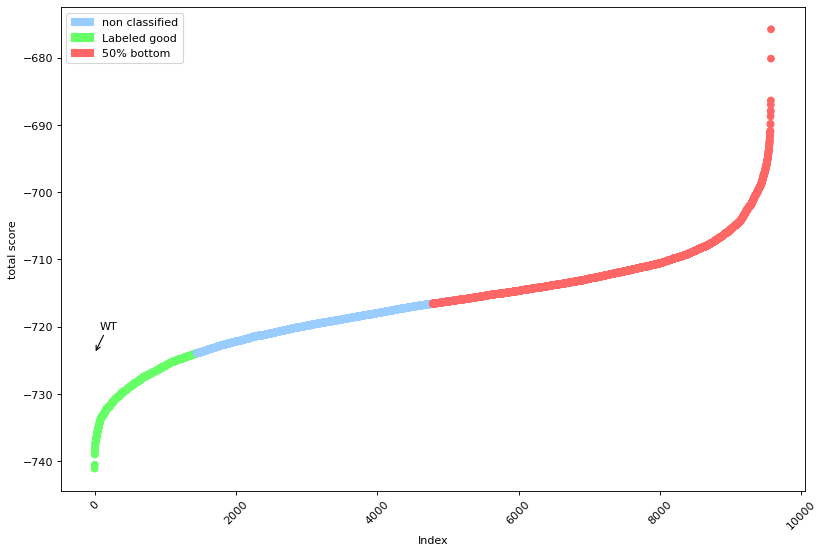

In [20]:
plt.figure(figsize=(12, 8), dpi=80, facecolor="w")

score_df["color"] = "#99ccff"
score_df.loc[score_df[LABEL] == 1, "color"] = "#66ff66"
score_df.loc[score_df[NLABEL] == 1, "color"] = "#ff6666"

plt.scatter(range(0, N), score_df.total_score.values, c=score_df.color)
plt.xlabel("Index")
plt.ylabel("total score")

plt.annotate(
    "WT",
    xy=(0, WT.total_score),
    xytext=(20, 20),
    textcoords="offset points",
    ha="right",
    va="bottom",
    # bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
)
plt.xticks(rotation=45)
plt.savefig("data.png", transparent=True, dpi=200)

patches = []
patches.append(mpatches.Patch(color="#99ccff", label="non classified"))
patches.append(mpatches.Patch(color="#66ff66", label="Labeled good"))
patches.append(mpatches.Patch(color="#ff6666", label="50% bottom"))
plt.legend(handles=patches)

plt.show()

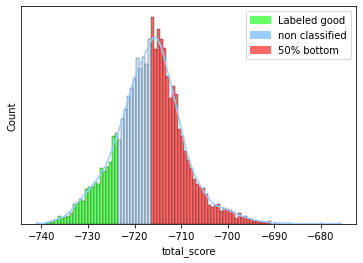

In [27]:
# plot the histogram
plt.figure(facecolor="w")
dist = sns.histplot(
    score_df["total_score"],
    color="#99ccff",
    kde=True,
    bins=101,
)

top_negative = min(score_df[score_df[NLABEL] == 1]["total_score"])
# color less than WT
for p in dist.patches:
    if p.get_x() < WT["total_score"]:
        p.set_facecolor("#66ff66")
    elif p.get_x() >= top_negative:
        p.set_facecolor("#ff6666")


plt.gca().set_yticks([])

patches = []

patches.append(mpatches.Patch(color="#66ff66", label="Labeled good"))
patches.append(mpatches.Patch(color="#99ccff", label="non classified"))
patches.append(mpatches.Patch(color="#ff6666", label="50% bottom"))
plt.legend(handles=patches)

plt.savefig("dist_scores.png", transparent=True, dpi=500)

### Features preparation
Creating the features for the NN to train on. We use one-hot encoding of the data 

In [28]:
encoded_table = pd.get_dummies(score_df[ALL_POSS_CHAIN])
encoded_table = encoded_table.loc[:, ~encoded_table.columns.duplicated()]
FEATURES = encoded_table.columns
score_df[FEATURES] = encoded_table
score_df.head()

,SCORE:,total_score,coordinate_constraint,designable,dslf_fa13,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,...,108A_Y,119A_L,123A_I,123A_L,123A_M,123A_T,123A_V,185A_A,185A_N,185A_V
124,SCORE:,-741.077,1.003,125.0,0.0,-1362.899,284.590,-406.992,2.512,46.389,...,0,1,1,0,0,0,0,0,1,0
818,SCORE:,-740.507,1.031,124.0,0.0,-1364.492,285.492,-407.371,2.503,46.259,...,0,1,1,0,0,0,0,0,1,0
508,SCORE:,-738.990,0.933,126.0,0.0,-1367.482,286.555,-406.779,2.518,46.431,...,0,1,1,0,0,0,0,0,1,0
943,SCORE:,-738.776,1.181,125.0,0.0,-1362.626,285.378,-406.673,2.531,46.366,...,0,1,1,0,0,0,0,0,1,0
270,SCORE:,-738.302,1.292,124.0,0.0,-1360.258,283.943,-405.154,2.523,46.305,...,0,1,1,0,0,0,0,0,1,0


### Split to train and test set

In [29]:
positive = score_df[score_df[LABEL] == 1]
negative = score_df[score_df[NLABEL] == 1]
training = pd.concat([positive, negative])
train, test = train_test_split(training, test_size=0.2, random_state=42)

Leaving only the columns needed for training

In [31]:
X_train = train[FEATURES]
y_train = pd.DataFrame(train[LABEL], columns=[LABEL])

X_test = test[FEATURES]
y_test = pd.DataFrame(test[LABEL], columns=[LABEL])

print(FEATURES)

Index(['42A_I', '42A_L', '42A_V', '44A_I', '44A_L', '44A_M', '46A_F', '61A_M',
       '61A_T', '61A_V', '64A_L', '68A_A', '68A_L', '68A_M', '68A_T', '68A_V',
       '69A_A', '69A_D', '69A_E', '69A_H', '69A_L', '69A_M', '69A_N', '69A_Q',
       '69A_W', '69A_Y', '110A_A', '110A_M', '110A_Y', '112A_I', '112A_T',
       '112A_V', '145A_A', '145A_F', '145A_I', '145A_M', '145A_S', '145A_T',
       '145A_V', '145A_Y', '150A_I', '150A_L', '150A_M', '150A_V', '163A_V',
       '165A_F', '167A_T', '181A_H', '181A_I', '181A_L', '181A_V', '181A_Y',
       '201A_F', '201A_L', '220A_I', '220A_L', '220A_V', '224A_V', '14A_I',
       '16A_I', '16A_V', '18A_F', '18A_L', '72A_A', '72A_C', '72A_G', '72A_I',
       '72A_S', '72A_T', '72A_V', '108A_A', '108A_E', '108A_F', '108A_I',
       '108A_L', '108A_M', '108A_P', '108A_Q', '108A_S', '108A_T', '108A_V',
       '108A_Y', '119A_L', '123A_I', '123A_L', '123A_M', '123A_T', '123A_V',
       '185A_A', '185A_N', '185A_V'],
      dtype='object')


### Save and Restore Data
Saving all datasets as csv files


In [32]:
score_df.to_csv(os.path.join(W_PATH, "all_data.pkl"))

X_train.to_pickle(os.path.join(W_PATH, "X_train.pkl"))
X_test.to_pickle(os.path.join(W_PATH, "X_test.pkl"))

y_train.to_pickle(os.path.join(W_PATH, "y_train.pkl"))
y_test.to_pickle(os.path.join(W_PATH, "y_test.pkl"))

### Restore all data and reinitialize whatever variables needed for later

In [34]:
score_df = pd.read_csv(os.path.join(W_PATH, "all_data.pkl"))

X_train = pd.read_pickle(os.path.join(W_PATH, "X_train.pkl"))
X_test = pd.read_pickle(os.path.join(W_PATH, "X_test.pkl"))

y_train = pd.read_pickle(os.path.join(W_PATH, "y_train.pkl"))
y_test = pd.read_pickle(os.path.join(W_PATH, "y_test.pkl"))

In [37]:
FEATURES = X_train.columns
LABEL = "y"
NLABEL = "negative"
N = len(score_df)
WT = score_df.loc[score_df["num_muts"] == 0, :].iloc[1]

assert WT.num_muts == 0

## 04 Training the neural net model

In [38]:
mlp = MLPClassifier(
    hidden_layer_sizes=(len(ALL_POSS)),
    activation="logistic",
    learning_rate="invscaling",
    random_state=42,
    verbose=True,
    max_iter=20000,
)
mlp.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Iteration 1, loss = 0.52583808
Iteration 2, loss = 0.50638546
Iteration 3, loss = 0.48540444
Iteration 4, loss = 0.46156887
Iteration 5, loss = 0.43536303
Iteration 6, loss = 0.40831637
Iteration 7, loss = 0.38160503
Iteration 8, loss = 0.35463040
Iteration 9, loss = 0.32933702
Iteration 10, loss = 0.30584260
Iteration 11, loss = 0.28384462
Iteration 12, loss = 0.26284144
Iteration 13, loss = 0.24409914
Iteration 14, loss = 0.22752166
Iteration 15, loss = 0.21187975
Iteration 16, loss = 0.19730815
Iteration 17, loss = 0.18481670
Iteration 18, loss = 0.17336145
Iteration 19, loss = 0.16354992
Iteration 20, loss = 0.15468370
Iteration 21, loss = 0.14596378
Iteration 22, loss = 0.13871716
Iteration 23, loss = 0.13193707
Iteration 24, loss = 0.12612128
Iteration 25, loss = 0.12083525
Iteration 26, loss = 0.11561481
Iteration 27, loss = 0.11126669
Iteration 28, loss = 0.10712914
Iteration 29, loss = 0.10345043
Iteration 30, loss = 0.10038335
Iteration 31, loss = 0.09700634
Iteration 32, los

MLPClassifier(activation='logistic', hidden_layer_sizes=26,
              learning_rate='invscaling', max_iter=20000, random_state=42,
              verbose=True)

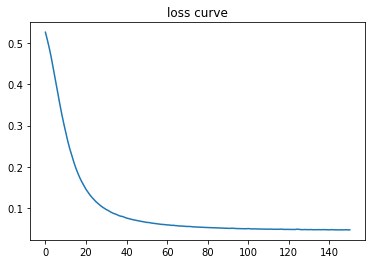

In [39]:
plt.figure(facecolor="w")
plt.ion()
ax = plt.gca()
ax.set_title("loss curve")
plt.plot(mlp.loss_curve_)

### Save the model using joblib

In [40]:
filename = "%s/model.sav" % W_PATH
joblib.dump(mlp, filename)

['/home/labs/fleishman/jonathaw/gfp_lib/analysis/notebooks_for_publication/htFuncLib/htFuncLib_notebook/model.sav']

### Load the model using joblib

In [42]:
filename = "%s/model.sav" % W_PATH
mlp = joblib.load(filename)

### Analyzing predictions

In [43]:
predictions = mlp.predict(score_df[FEATURES])

In [45]:
a = confusion_matrix(score_df[LABEL], predictions)
rates = pd.DataFrame(
    [[a[0, 0], a[0, 1], a[1, 0], a[1, 1]]], columns=["TN", "FP", "FN", "TP"]
)
rates

,TN,FP,FN,TP
0,7103,1027,47,1397


In [46]:
print(classification_report(score_df[LABEL], predictions))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      8130
           1       0.58      0.97      0.72      1444

    accuracy                           0.89      9574
   macro avg       0.78      0.92      0.83      9574
weighted avg       0.93      0.89      0.90      9574



## 05 Rank mutaitons by EpiNNet
the following blocks use the EpiNNet model to rank all tested mutations,
refer to the weights_activations_1 column as rank

In [47]:
pred_weights = pd.DataFrame(columns=X_train.columns)  # just a diagonal matrix
N_cols = len(pred_weights.columns)
for i in range(N_cols):
    zeros = np.zeros(N_cols)
    zeros[i] = 1
    pred_weights.loc[len(pred_weights)] = zeros
weights_activations = mlp.predict_proba(pred_weights)

In [49]:
results = pd.DataFrame([i.split("_") for i in FEATURES], columns=["position", "AA"])
# results["weight"] = weights
results["weights_activations_0"] = weights_activations[:, 0]
results["weights_activations_1"] = weights_activations[:, 1]

results.sort_values("weights_activations_1", ascending=False, inplace=True)

with pd.option_context(
    "display.max_rows", None, "display.max_columns", None
):  # more options can be specified also
    print(results)

   position AA  weights_activations_0  weights_activations_1
11      68A  A               0.021914               0.978086
25      69A  Y               0.048885               0.951115
69      72A  V               0.124386               0.875614
20      69A  L               0.174842               0.825158
13      68A  M               0.378642               0.621358
50     181A  V               0.422138               0.577862
26     110A  A               0.514875               0.485125
53     201A  L               0.593882               0.406118
48     181A  I               0.645865               0.354135
9       61A  V               0.674059               0.325941
80     108A  V               0.676861               0.323139
68      72A  T               0.680682               0.319318
87     123A  V               0.687758               0.312242
64      72A  C               0.718698               0.281302
73     108A  I               0.781867               0.218133
51     181A  Y          

### Analyzing predictions

In [50]:
predictions = mlp.predict(X_test)

In [51]:
a = confusion_matrix(y_test, predictions)
print("TN:", a[0, 0])
print("FP:", a[0, 1])
print("FN:", a[1, 0])
print("TP:", a[1, 1])

TN: 920
FP: 12
FN: 16
TP: 299


## 06 Choose mutations
Here we choose the top ranked mutations. The criteria here is that the mutation is being ranked positive.  
You may change the criteria, for example to half of the positions. Play with the criteria to get the wanted number of mutants.  

In [60]:
def parse_resfile(f):
    df = pd.read_csv(f, sep="\s+", skiprows=2, names=["pos", "chain", "PIKAA", "AAs"])
    df["len_AAs"] = df.AAs.map(len)
    df["num_chain"] = df["pos"].astype(str) + df["chain"]
    return df

In [65]:
def get_resfile(results):
    """Results should contain only the wanted mutations.
    Assumes it has the columns: position, AA
    :return: The resfile corresponding for the positions and AAs in the table
    """
    res_space = {}
    # reduced_resfile = ResFile()
    for pos, data in results.groupby("position"):
        # reduced_resfile.resfile[pos] = "".join(data.AA.tolist())
        res_space[pos] = data.AA.tolist()
    return res_space

In [55]:
print("Original WT positions")
print(WT[ALL_POSS_CHAIN])

Original WT positions
42A     L
44A     L
46A     F
61A     V
64A     L
68A     V
69A     Q
110A    A
112A    V
145A    Y
150A    V
163A    V
165A    F
167A    T
181A    H
201A    L
220A    L
224A    V
14A     I
16A     V
18A     L
72A     S
108A    T
119A    L
123A    I
185A    N
Name: 1447, dtype: object


## 07 Find the best sequence space
These blocks will help you construct the final sequence space.
it iteratively adds additional mutations (from the top ranked mutaitons, as ranked by the EpiNNet model).
for each potential sequence space, the size of the encoded library, and it's estimated good Vs. bad number of deisgns are evaluated.

In [254]:
results.sort_values("weights_activations_1", ascending=False, inplace=True)

In [154]:
def get_seq_space_upto_row(sub_results):
    seq_space = {}
    for p, wt in poss_to_wt.items():
        aas = sub_results.loc[sub_results["position"] == p, "AA"].values
        seq_space[p] = [wt] + [aa for aa in aas if aa != wt]
    return seq_space


def get_sub_score_df(sc_df, seq_space):
    sc_df = sc_df.copy()
    for p, aas in seq_space.items():
        sc_df = sc_df.loc[sc_df[p].isin(aas)]
    return sc_df


summ_df = pd.DataFrame(
    columns=["i"] + ALL_POSS_CHAIN + ["good", "bad", "rest", "total"]
)
for i in tqdm(range(len(results))):
    seq_space = get_seq_space_upto_row(results.iloc[:i])
    sub_score_df = get_sub_score_df(score_df, seq_space)
    row = {p: "".join(seq_space[p]) for p in ALL_POSS_CHAIN}
    row["i"] = i
    row["good"] = len(sub_score_df.loc[sub_score_df["y"] == 1])
    row["bad"] = len(sub_score_df.loc[sub_score_df["negative"] == 1])
    row["total"] = len(sub_score_df)
    summ_df = pd.concat([summ_df, pd.DataFrame(data=row, index=[i])], ignore_index=True)
summ_df["lib_size"] = summ_df.apply(
    lambda r: np.product([len(r[p]) for p in ALL_POSS_CHAIN]), axis=1
)
summ_df["lib_size_log10"] = np.log10(summ_df["lib_size"])
summ_df["rest"] = summ_df.total - summ_df.good - summ_df.bad
summ_df["good_rel"] = summ_df["good"] / summ_df["total"]
summ_df["bad_rel"] = summ_df["bad"] / summ_df["total"]
summ_df["rest_rel"] = summ_df["rest"] / summ_df["total"]
display_all(summ_df)

  0%|          | 0/91 [00:00<?, ?it/s]

,i,42A,44A,46A,61A,64A,68A,69A,110A,112A,145A,150A,163A,165A,167A,181A,201A,220A,224A,14A,16A,18A,72A,108A,119A,123A,185A,good,bad,rest,total,lib_size,lib_size_log10,good_rel,bad_rel,rest_rel
0,0,L,L,F,V,L,V,Q,A,V,Y,V,V,F,T,H,L,L,V,I,V,L,S,T,L,I,N,0,0,48,48,1,0.000000,0.0,0.0,1.0
1,1,L,L,F,V,L,VA,Q,A,V,Y,V,V,F,T,H,L,L,V,I,V,L,S,T,L,I,N,7,0,48,55,2,0.301030,0.127273,0.0,0.872727
2,2,L,L,F,V,L,VA,QY,A,V,Y,V,V,F,T,H,L,L,V,I,V,L,S,T,L,I,N,12,0,48,60,4,0.602060,0.2,0.0,0.8
3,3,L,L,F,V,L,VA,QY,A,V,Y,V,V,F,T,H,L,L,V,I,V,L,SV,T,L,I,N,13,0,54,67,8,0.903090,0.19403,0.0,0.80597
4,4,L,L,F,V,L,VA,QYL,A,V,Y,V,V,F,T,H,L,L,V,I,V,L,SV,T,L,I,N,18,0,57,75,12,1.079181,0.24,0.0,0.76
5,5,L,L,F,V,L,VAM,QYL,A,V,Y,V,V,F,T,H,L,L,V,I,V,L,SV,T,L,I,N,27,0,57,84,18,1.255273,0.321429,0.0,0.678571
6,6,L,L,F,V,L,VAM,QYL,A,V,Y,V,V,F,T,HV,L,L,V,I,V,L,SV,T,L,I,N,33,0,60,93,36,1.556303,0.354839,0.0,0.645161
7,7,L,L,F,V,L,VAM,QYL,A,V,Y,V,V,F,T,HV,L,L,V,I,V,L,SV,T,L,I,N,33,0,60,93,36,1.556303,0.354839,0.0,0.645161
8,8,L,L,F,V,L,VAM,QYL,A,V,Y,V,V,F,T,HV,L,L,V,I,V,L,SV,T,L,I,N,33,0,60,93,36,1.556303,0.354839,0.0,0.645161
9,9,L,L,F,V,L,VAM,QYL,A,V,Y,V,V,F,T,HVI,L,L,V,I,V,L,SV,T,L,I,N,38,0,65,103,54,1.732394,0.368932,0.0,0.631068


### Sub-sequence space bar plot
The following bar plot shows the good/bad/unknown rates for all sub sequence spaces, as ranked by 

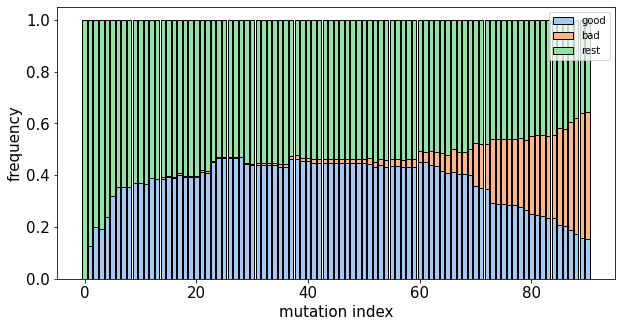

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
bottoms = [0] * len(summ_df)

for j, status in enumerate(["good", "bad", "rest"]):
    ax.bar(
        x=summ_df.i,
        height=summ_df[f"{status}_rel"],
        bottom=bottoms,
        width=0.8,
        label=status,
        facecolor=sns.color_palette("pastel", 3)[j],
        edgecolor="k",
    )
    bottoms = [b + s for b, s in zip(bottoms, summ_df[f"{status}_rel"])]
ax.set_xlabel("mutation index")
ax.set_ylabel("frequency")
plt.legend()
plt.show()

### Twick the lower and upper limits to find your favorite sequence space
the numbers in the next block will help you examine sequence spaces encoding library sizes in the range you specify

In [215]:
summ_df.loc[summ_df.lib_size.between(100000, 1000000)]

,i,42A,44A,46A,61A,64A,68A,69A,110A,112A,...,185A,good,bad,rest,total,lib_size,lib_size_log10,good_rel,bad_rel,rest_rel
31,31,L,LI,F,V,L,VAM,QYLM,A,VI,...,NV,172,4,216,392,115200,5.061452,0.438776,0.010204,0.55102
32,32,L,LI,F,V,L,VAM,QYLM,A,VI,...,NV,172,4,216,392,115200,5.061452,0.438776,0.010204,0.55102
33,33,L,LI,F,V,L,VAM,QYLM,A,VI,...,NV,172,4,216,392,115200,5.061452,0.438776,0.010204,0.55102
34,34,L,LI,F,V,L,VAM,QYLM,A,VI,...,NV,172,4,216,392,115200,5.061452,0.438776,0.010204,0.55102
35,35,L,LI,F,V,L,VAM,QYLM,A,VI,...,NV,172,4,221,397,138240,5.140634,0.433249,0.010076,0.556675
36,36,L,LI,F,V,L,VAM,QYLM,A,VI,...,NV,172,4,221,397,138240,5.140634,0.433249,0.010076,0.556675
37,37,L,LI,F,V,L,VAMT,QYLM,A,VI,...,NV,201,5,228,434,184320,5.265572,0.463134,0.011521,0.525346
38,38,L,LI,F,V,L,VAMT,QYLM,A,VI,...,NV,243,7,273,523,276480,5.441664,0.464627,0.013384,0.521989
39,39,L,LI,F,V,L,VAMT,QYLM,A,VI,...,NV,257,8,302,567,414720,5.617755,0.453263,0.014109,0.532628
40,40,L,LI,F,V,L,VAMT,QYLM,A,VI,...,NV,257,8,302,567,414720,5.617755,0.453263,0.014109,0.532628


In [226]:
chosen_seq_space = get_seq_space_upto_row(results.iloc[:40])
print(
    f"the chosen sequence space encodes a library of size {np.product(list(map(len, chosen_seq_space.values())))}"
)
print("position\tAAs")
for p, aas in chosen_seq_space.items():
    print(f'{p}\t\t{"".join(aas)}')
reduced_chosen_seq_space = {
    p: aas for p, aas in chosen_seq_space.items() if len(aas) > 1
}

the chosen sequence space encodes a library of size 414720
position	AAs
42A		L
44A		LI
46A		F
61A		V
64A		L
68A		VAMT
69A		QYLM
110A		A
112A		VI
145A		YFI
150A		VIL
163A		V
165A		F
167A		T
181A		HVIY
201A		L
220A		L
224A		V
14A		I
16A		V
18A		L
72A		SVTCA
108A		TVILEM
119A		L
123A		IVL
185A		NV


## 08 Test 10k designs
create and analyse 10,000 random designs from the EpiNNet enriched sequence space compared to the filtered sequence space

In [274]:
filtered_resfile = parse_resfile(RESFILES[CHOSEN_DDG])
filtered_seq_space = dict(
    zip(
        list(map(lambda x: f"{x}A", filtered_resfile["pos"])),
        map(list, filtered_resfile["AAs"]),
    )
)
reduced_filtered_seq_space = {
    p: aas for p, aas in filtered_seq_space.items() if len(aas) > 1
}
reduced_filtered_seq_space, reduced_chosen_seq_space

({'16A': ['V', 'I'],
  '18A': ['L', 'F'],
  '42A': ['L', 'I', 'V'],
  '44A': ['L', 'I', 'M'],
  '61A': ['V', 'M', 'T'],
  '66A': ['Y', 'F', 'L', 'M'],
  '68A': ['V', 'A', 'L', 'M', 'T'],
  '69A': ['Q', 'A', 'D', 'E', 'H', 'L', 'M', 'N', 'W', 'Y'],
  '72A': ['S', 'A', 'C', 'G', 'I', 'T', 'V'],
  '108A': ['T', 'A', 'E', 'F', 'I', 'L', 'M', 'P', 'Q', 'S', 'V', 'Y'],
  '110A': ['A', 'M', 'Y'],
  '112A': ['V', 'I', 'T'],
  '123A': ['I', 'L', 'M', 'T', 'V'],
  '145A': ['Y', 'A', 'F', 'I', 'M', 'S', 'T', 'V'],
  '150A': ['V', 'I', 'L', 'M'],
  '181A': ['H', 'I', 'L', 'V', 'Y'],
  '185A': ['N', 'A', 'V'],
  '201A': ['L', 'F'],
  '220A': ['L', 'I', 'V']},
 {'44A': ['L', 'I'],
  '68A': ['V', 'A', 'M', 'T'],
  '69A': ['Q', 'Y', 'L', 'M'],
  '112A': ['V', 'I'],
  '145A': ['Y', 'F', 'I'],
  '150A': ['V', 'I', 'L'],
  '181A': ['H', 'V', 'I', 'Y'],
  '72A': ['S', 'V', 'T', 'C', 'A'],
  '108A': ['T', 'V', 'I', 'L', 'E', 'M'],
  '123A': ['I', 'V', 'L'],
  '185A': ['N', 'V']})

In [276]:
TEST_10K = "%s/test_10k" % W_PATH
create_dir(TEST_10K)

total = 0
num_muts_per_job = np.random.choice(
    list(range(1, len(reduced_chosen_seq_space))), size=10000
)
for name, seq_space in tqdm(
    zip(["EpiNNet", "Filtered"], [reduced_chosen_seq_space, reduced_filtered_seq_space])
):
    create_dir(f"{TEST_10K}/{name}/")
    create_dir(f"{TEST_10K}/{name}/scores")

    with open(f"{TEST_10K}/{name}/selected_combinations.txt", "w+") as fout:
        job = f"{ROSETTA_SCRIPTS} "
        job += f"-database {ROSETTA_DB} "
        job += f"@{W_PATH}/initial_data/flags "
        job += f"-out:prefix wt_ "
        job += f"-out:file:score_only {TEST_10K}/{name}/scores/wt.sc "

        job += f"-parser:script_vars "
        job += f'all_ress={",".join(f"{p}A" for p in sorted(ALL_POSS))} '
        job += "\n"

        fout.write(job)
        for i in range(10000):
            job = f"{ROSETTA_SCRIPTS} -database {ROSETTA_DB} "
            job += f"@{W_PATH}/initial_data/flags "
            muts = {}
            for p in np.random.choice(list(seq_space.keys()), num_muts_per_job[i]):
                muts[p] = np.random.choice(seq_space[p][1:], 1)[0]

            job += f'-out:prefix {"_".join(p+aa for p, aa in muts.items())}_ '
            job += f'-out:file:score_only {TEST_10K}/{name}/scores/{"_".join(p+aa for p, aa in muts.items())}.sc '

            job += f"-parser:script_vars "
            job += f'all_ress={",".join(f"{p}A" for p in sorted(ALL_POSS))} '
            for j, (pos, aa) in enumerate(muts.items()):
                job += f"new_res{j+1}={ONE_2_THREE[aa]} target{j+1}={pos} "
            job += "\n"
            fout.write(job)
            total += 1
print(f"\nCreated a total of {total} jobs.")

0it [00:00, ?it/s]


Created a total of 20000 jobs.


<AxesSubplot:ylabel='Count'>

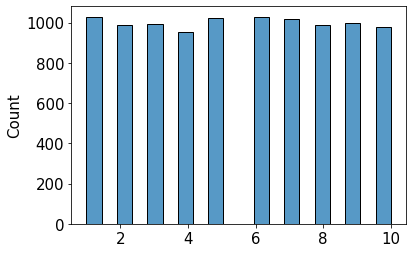

In [250]:
sns.histplot(num_muts_per_job)

### this is where you run the 10k jobs, then coallece the scores into two score files

In [291]:
first = True
with open(Path(TEST_10K) / "all_10k_test.sc", "w+") as all_fout:
    for name in ["EpiNNet", "Filtered"]:
        for i, f in tqdm(enumerate((Path(TEST_10K) / name / "scores").glob("*.sc"))):
            txt = open(f, "r").read().split("\n")
            if first:
                all_fout.writelines(txt[1] + "\tseq_space\n")
                first = False
            all_fout.writelines(txt[2] + f"\t{name}\n")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [292]:
test_10k_df = pd.read_csv(Path(TEST_10K) / "all_10k_test.sc", sep="\s+")
test_10k_df

,SCORE:,total_score,coordinate_constraint,designable,dslf_fa13,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,...,hbond_sr_bb,lk_ball_wtd,omega,p_aa_pp,pro_close,rama_prepro,ref,yhh_planarity,description,seq_space
0,SCORE:,-738.404,1.498,126.0,0.0,-1367.768,291.082,-410.904,2.519,46.823,...,-27.746,-13.610,29.472,-55.551,0.669,4.892,36.435,0.062,150AL_108AE_68AA_44AI_refined,EpiNNet
1,SCORE:,-734.472,1.651,124.0,0.0,-1369.813,284.028,-402.707,2.546,46.437,...,-26.517,-13.187,29.058,-53.409,0.660,8.945,48.181,0.058,123AV_69AL_44AI_72AA_108AM_145AF_refined,EpiNNet
2,SCORE:,-728.601,1.529,123.0,0.0,-1373.921,294.529,-402.781,2.562,46.533,...,-27.115,-12.683,30.047,-53.539,0.697,4.429,45.050,0.065,112AI_108AM_69AY_181AY_refined,EpiNNet
3,SCORE:,-720.401,1.191,123.0,0.0,-1360.067,286.651,-406.844,2.545,46.197,...,-26.162,-13.382,30.452,-53.148,0.610,8.815,43.591,0.062,150AL_181AI_refined,EpiNNet
4,SCORE:,-723.293,0.952,124.0,0.0,-1362.805,286.028,-404.980,2.521,46.611,...,-26.590,-13.576,30.646,-52.808,0.660,9.237,40.780,0.063,150AI_44AI_68AT_refined,EpiNNet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16846,SCORE:,-725.081,1.550,127.0,0.0,-1364.213,290.732,-403.139,2.564,46.530,...,-26.013,-13.928,27.695,-54.688,0.515,5.572,42.015,0.053,123AT_68AM_44AI_18AF_181AY_72AT_16AI_refined,Filtered
16847,SCORE:,-720.865,1.305,124.0,0.0,-1362.839,288.284,-403.624,2.528,46.564,...,-26.330,-13.737,30.115,-52.222,0.663,9.515,40.648,0.063,16AI_150AL_refined,Filtered
16848,SCORE:,-712.979,2.070,126.0,0.0,-1345.528,282.561,-398.000,2.521,45.660,...,-26.652,-13.113,29.696,-54.456,0.590,8.206,46.531,0.053,44AM_108AA_181AI_42AI_69AA_61AM_123AL_refined,Filtered
16849,SCORE:,-695.142,2.713,124.0,0.0,-1356.958,291.691,-394.701,2.524,46.498,...,-26.807,-15.331,30.975,-53.877,0.895,9.006,38.212,0.071,108AP_44AM_201AF_42AV_150AI_220AV_123AM_61AT_r...,Filtered


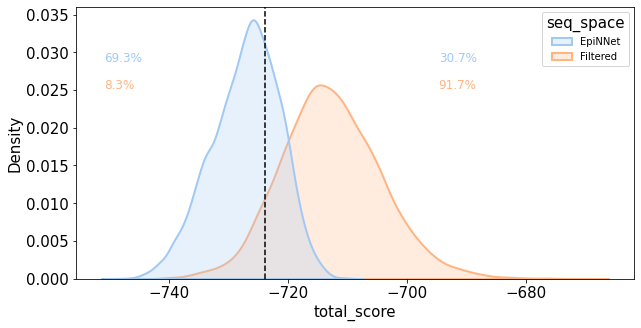

In [301]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), facecolor="w")
sns.kdeplot(
    data=test_10k_df,
    x="total_score",
    hue="seq_space",
    palette="pastel",
    fill=True,
    ax=ax,
    linewidth=2,
)
plt.axvline(WT.total_score, linestyle="--", c="k")

for i, (name, height) in enumerate(zip(["EpiNNet", "Filtered"], [0.8, 0.7])):
    for over_under, left_right in zip(["over", "under"], [0.65, 0.05]):
        if over_under == "under":
            top = len(
                test_10k_df.loc[
                    (test_10k_df["seq_space"] == name)
                    & (test_10k_df["total_score"] < WT.total_score)
                ]
            )
        else:
            top = len(
                test_10k_df.loc[
                    (test_10k_df["seq_space"] == name)
                    & (test_10k_df["total_score"] > WT.total_score)
                ]
            )
        ax.text(
            left_right,
            height,
            f'{100*top/len(test_10k_df.loc[test_10k_df["seq_space"] == name]):.1f}%',
            color=sns.color_palette("pastel")[i],
            size=12,
            transform=ax.transAxes,
        )


plt.show()

In [304]:
for name, seq_space in zip(
    ["EpiNNet", "Filtered"], [reduced_chosen_seq_space, reduced_filtered_seq_space]
):
    print(
        f'select {name}_poss, resi {"+".join(map(lambda x: x[:-1], seq_space.keys()))}'
    )

select EpiNNet_poss, resi 44+68+69+112+145+150+181+72+108+123+185
select Filtered_poss, resi 16+18+42+44+61+66+68+69+72+108+110+112+123+145+150+181+185+201+220
